In [1]:
%matplotlib inline
import os
import time
import numpy
import pandas as pd
import matplotlib

In [2]:
# Example of coupled execution
# log_files = {'new': 'slurm-4240.out'}

# Example of completed uncoupled, with bad node?
log_files = {'new': 'slurm-4457.out'}

# Example of completed uncoupled, without bad node?
log_files = {'new': 'slurm-4459.out'}

log_files = {'new': 'slurm-4714.out'}

# log_files = {'new': 'slurm-4236.out'}
# log_files = {1: 'slurm-3600.out', 4: 'slurm-3601.out', 16: 'slurm-3602.out', 'rwlock': 'slurm-4235.out'}

In [3]:
 def log_file_to_dataframe(log_file):
    fp = open(log_file, 'r')
    perf_records = []
    for line in fp:
        if line.startswith('PE ') and line.find('- total') != -1:
            tokens = line.split()

            # Sample line in log file:
            #   PE 6 - total 1336.802000 ms - metadata 54.481000 ms (50.733000 0.000000) - \
            #     summary 3.805000 ms (1.763000 0.072000 1.970000 | 0.065000 0.037000 0.048000 1.820000) - \
            #     edges 1278.047000 ms (1190.644000 80.641000) - neighbor updates 0.411000 ms - \
            #     abort 0.058000 ms - 0 spins - 9 / 16 PE neighbors  - partition window = , 1522 / 28900 active - \
            #     aborting? 0 - last step? 0 - remote cache hits=6688 misses=3553 age misses=0, feature cache hits=0 misses=0
            #
            # Sample new line in log file:
            #   PE 11 - total 42.046000 ms - metadata 26.715000 ms (26.212000 0.000000) - \
            #     summary 4.765000 ms (0.133000 0.023000 4.609000 | 1.428000 1.406000 1.281000 0.481000) - \
            #     edges 10.411000 ms (2.730000 7.445000) - neighbor updates 0.111000 ms - coupling 0.020000 ms - \
            #     throttling 0.024000 ms - 0 spins - 6 / 256 PE neighbors  - partition window = , 43 / 10000 active - \
            #     aborting? 0 - last step? 0 - remote cache hits=1611 misses=375 age misses=0, feature cache hits=0 misses=0
            index = 1
            pe = int(tokens[index])
            index += 3
            
            timestep = int(tokens[index])
            index += 3
            
            total = float(tokens[index])
            index += 4
            
            metadata = float(tokens[index])
            index += 6
            
            summary = float(tokens[index])
            index += 2
            summary_actor_partitions = float(tokens[index][1:])
            index += 1
            summary_time_window = float(tokens[index])
            index += 1
            summary_update_neighbors = float(tokens[index])
            index += 2
            summary_update_neighbors_lock = float(tokens[index])
            index += 1
            summary_update_neighbors_getmem = float(tokens[index])
            index += 1
            summary_update_neighbors_unlock = float(tokens[index])
            index += 1
            summary_update_neighbors_body = float(tokens[index][:len(tokens[index]) - 1])
            index += 3
            
            edges = float(tokens[index])
            index += 2
            edges_updates = float(tokens[index][1:])
            index += 1
            edges_getmem = float(tokens[index][:-1])
            index += 4
            
            neighbor_updates = float(tokens[index])
            index  += 5
            
            coupled_values = float(tokens[index])
            index += 4
            
            coupling = float(tokens[index])
            index += 2
            
            n_coupled_spins_str = tokens[index]
            n_coupled_spins_str = n_coupled_spins_str[1:]
            n_coupled_spins_str = n_coupled_spins_str[:len(n_coupled_spins_str) - 1]
            n_coupled_spins = int(n_coupled_spins_str)
            index += 3
            
            throttling = float(tokens[index])
            index += 3
            
            spins = int(tokens[index])
            index += 3
            
            n_neighbors = int(tokens[index])
            index += 10
            
            active_partitions = int(tokens[index])
            index += 14
            
            cache_hits_str = tokens[index]
            cache_hits = int(cache_hits_str.split('=')[1])
            index += 1
            
            cache_misses_str = tokens[index]
            cache_misses = int(cache_misses_str.split('=')[1])
            index += 2
            
            cache_age_misses_str = tokens[index]
            cache_age_misses_str = cache_age_misses_str.split('=')[1]
            cache_age_misses_str = cache_age_misses_str[:-1]
            cache_age_misses = int(cache_age_misses_str)

            perf_records.append({'pe': pe,
                                 'timestep': timestep,
                                 'total': total,
                                 'metadata': metadata,
                                 'summary': summary,
                                 'summary_actor_partitions': summary_actor_partitions,
                                 'summary_time_window': summary_time_window,
                                 'summary_update_neighbors': summary_update_neighbors,
                                 'summary_update_neighbors_lock': summary_update_neighbors_lock,
                                 'summary_update_neighbors_getmem': summary_update_neighbors_getmem,
                                 'summary_update_neighbors_unlock': summary_update_neighbors_unlock,
                                 'summary_update_neighbors_body': summary_update_neighbors_body,
                                 'edges': edges,
                                 'edges_updates': edges_updates,
                                 'edges_getmem': edges_getmem,
                                 'neighbor_updates': neighbor_updates,
                                 'coupling': coupling,
                                 'n_coupled_spins': n_coupled_spins,
                                 'coupled_values': coupled_values,
                                 'throttling': throttling,
                                 'spins': spins,
                                 'n_neighbors': n_neighbors,
                                 'active_partitions': active_partitions,
                                 'cache_hits': cache_hits,
                                 'cache_misses': cache_misses,
                                 'cache_age_misses': cache_age_misses})
    fp.close()
    return pd.DataFrame(perf_records)

In [4]:
dfs = {}
for nnodes in log_files:
    dfs[nnodes] = log_file_to_dataframe(log_files[nnodes])

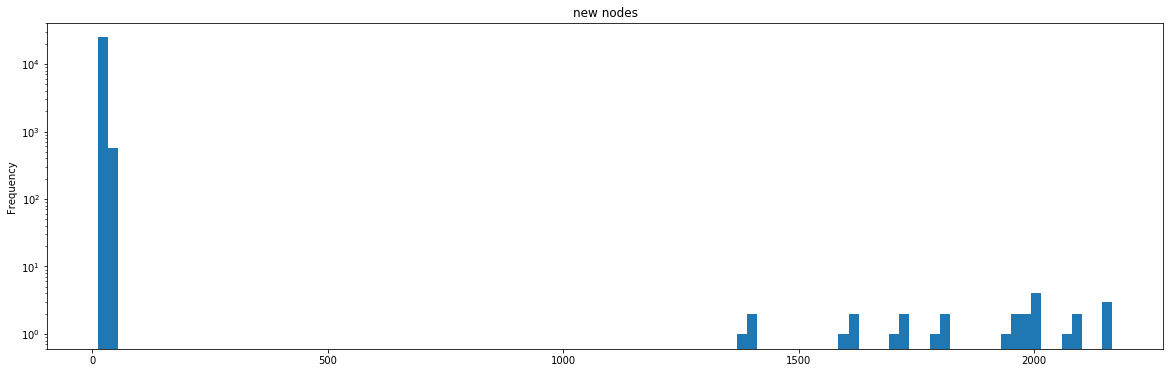

In [5]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['total'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes', logy = True)

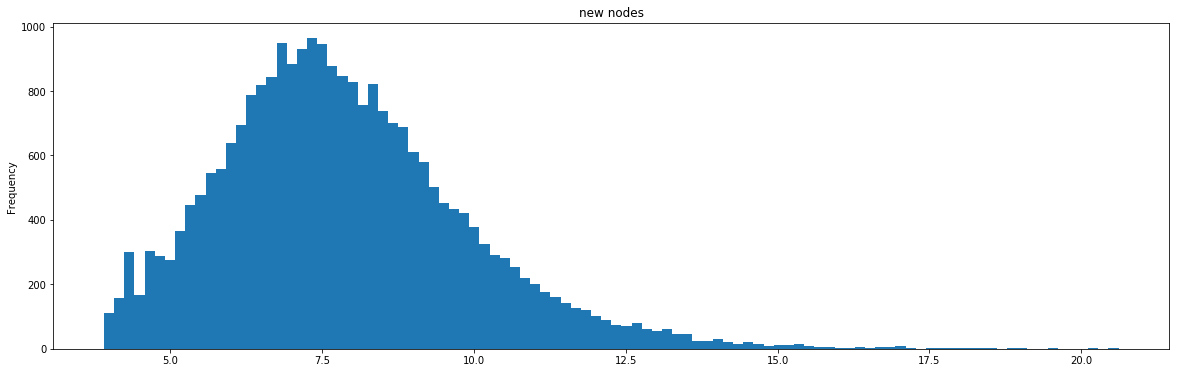

In [6]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['summary'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

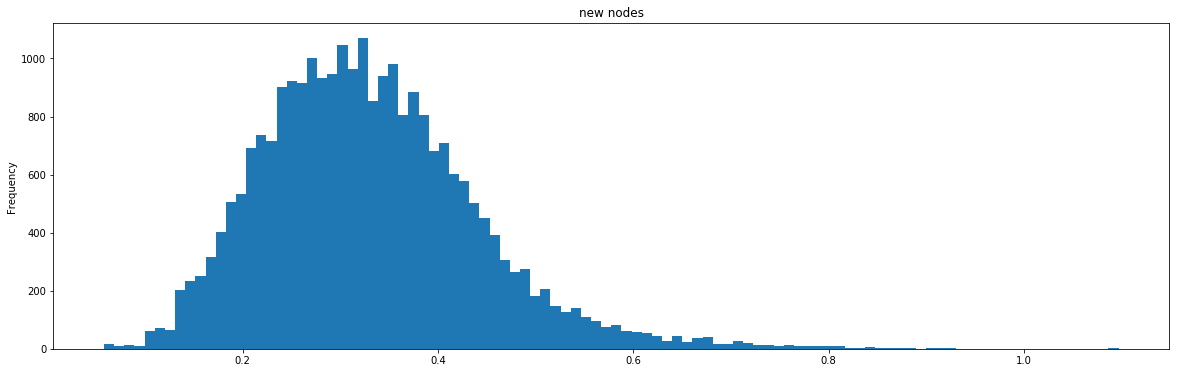

In [7]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['metadata'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

In [8]:
dfs['new'].columns

Index([u'active_partitions', u'cache_age_misses', u'cache_hits',
       u'cache_misses', u'coupled_values', u'coupling', u'edges',
       u'edges_getmem', u'edges_updates', u'metadata', u'n_coupled_spins',
       u'n_neighbors', u'neighbor_updates', u'pe', u'spins', u'summary',
       u'summary_actor_partitions', u'summary_time_window',
       u'summary_update_neighbors', u'summary_update_neighbors_body',
       u'summary_update_neighbors_getmem', u'summary_update_neighbors_lock',
       u'summary_update_neighbors_unlock', u'throttling', u'timestep',
       u'total'],
      dtype='object')

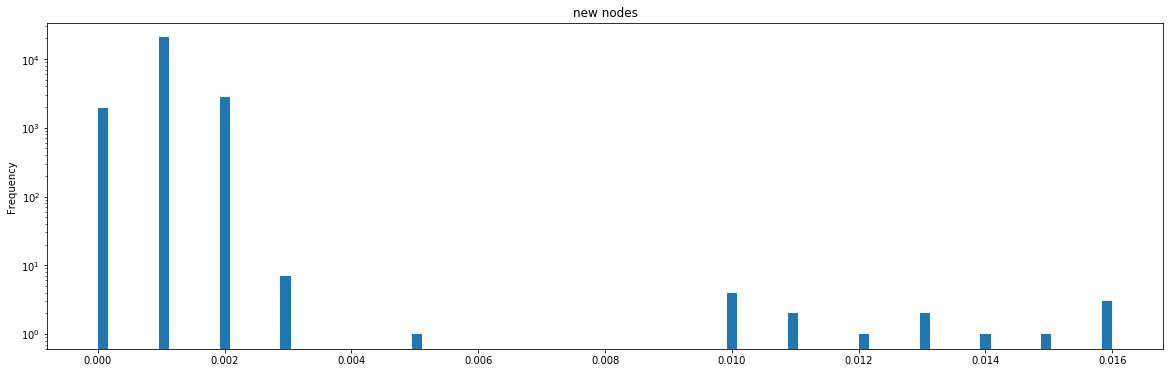

In [9]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['coupling'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes', logy = True)

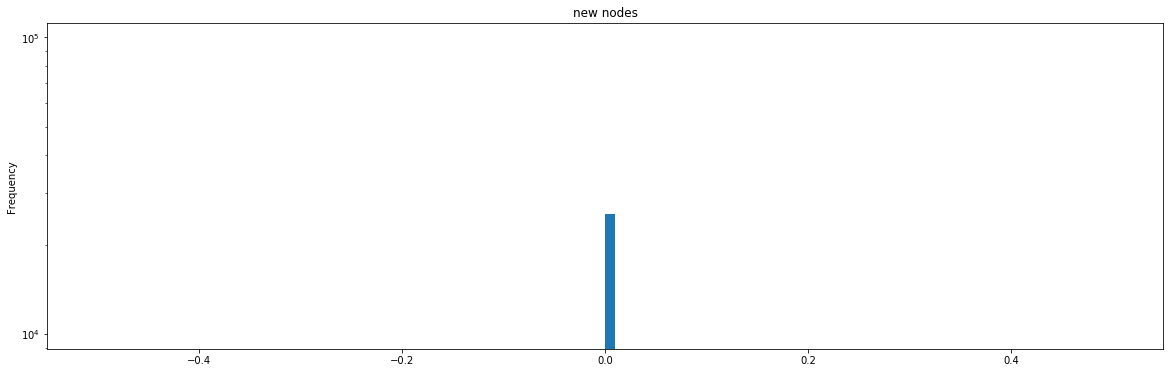

In [10]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['n_coupled_spins'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes', logy = True)

In [11]:
dfs['new'].sort_values(by = 'coupling', ascending = False)

,active_partitions,cache_age_misses,cache_hits,cache_misses,coupled_values,coupling,edges,edges_getmem,edges_updates,metadata,...,summary_actor_partitions,summary_time_window,summary_update_neighbors,summary_update_neighbors_body,summary_update_neighbors_getmem,summary_update_neighbors_lock,summary_update_neighbors_unlock,throttling,timestep,total
2684,44,753,3863,377,0.020,0.016,18.793,16.199,2.243,0.253,...,0.023,0.023,5.593,0.519,1.623,1.856,1.588,0.074,13,24.876
13949,47,3513,21119,404,0.033,0.016,11.873,8.907,2.265,0.415,...,0.034,0.024,8.943,0.543,2.584,3.100,2.706,0.078,60,21.493
16275,45,4509,23494,400,0.030,0.016,9.908,7.483,2.087,0.211,...,0.020,0.019,10.214,0.546,3.418,3.304,2.935,0.036,71,20.529
15429,49,7093,20822,423,0.024,0.015,13.343,10.589,2.366,0.334,...,0.023,0.033,7.303,0.526,2.301,2.355,2.112,0.045,66,21.206
810,47,0,1333,429,0.014,0.014,9.762,7.212,2.271,0.328,...,0.021,0.018,5.389,0.548,1.557,1.694,1.580,0.030,4,15.631
23299,48,9521,34967,440,0.018,0.013,12.198,9.667,2.237,0.363,...,0.021,0.017,5.768,0.581,1.772,1.782,1.625,0.032,100,18.481
1097,44,336,2092,336,0.017,0.013,7.940,5.716,2.018,0.406,...,0.032,0.021,11.995,0.601,3.759,4.098,3.518,0.032,8,20.529
14224,46,4477,20856,379,0.020,0.012,11.220,8.768,2.195,0.300,...,0.024,0.030,7.878,0.538,2.418,2.513,2.395,0.035,66,19.586
24934,45,2328,20605,365,0.014,0.011,7.243,5.229,1.825,0.228,...,0.018,0.016,4.332,0.519,1.344,1.295,1.160,0.032,62,11.936
9664,46,2626,13160,356,0.016,0.011,10.389,8.262,1.892,0.326,...,0.027,0.020,8.672,0.562,2.521,2.922,2.653,0.050,44,19.580


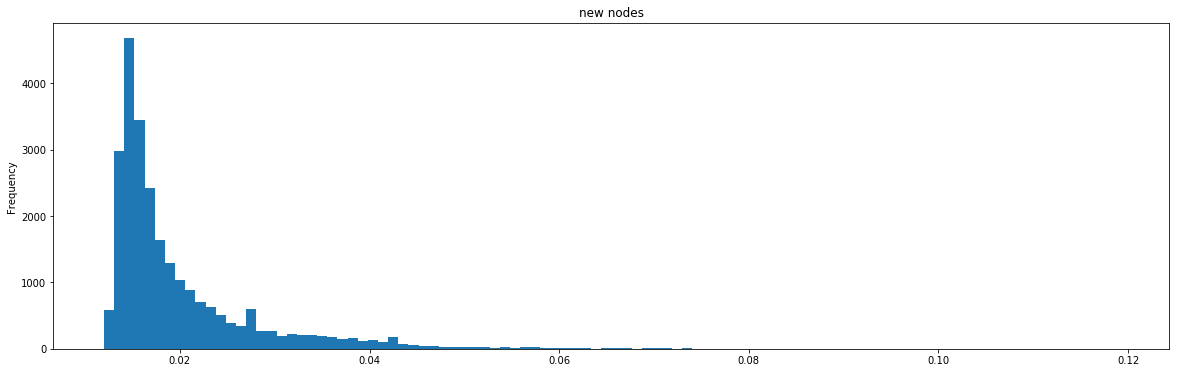

In [12]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['coupled_values'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes')

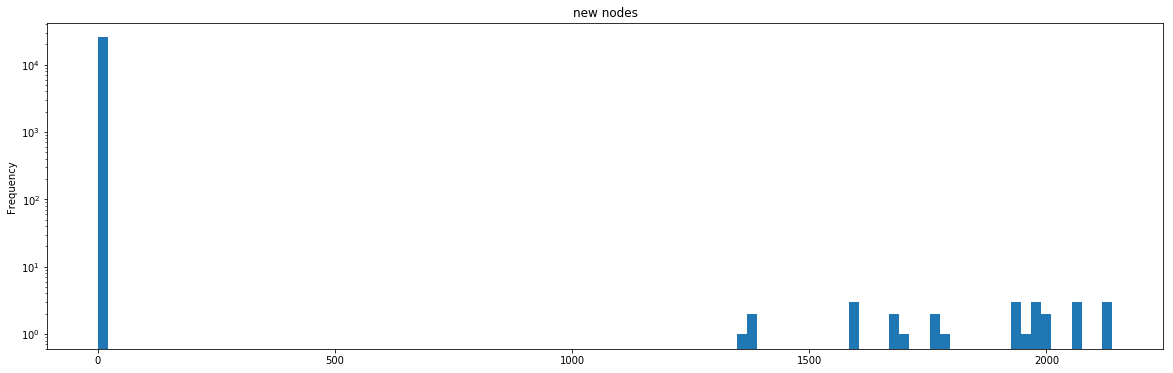

In [13]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['throttling'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes', logy = True)

In [17]:
# Who does the most throttling and least throttling?
dfs['new'].sort_values(by = 'throttling')[['throttling', 'pe', 'timestep']].head(10)

,throttling,pe,timestep
740,0.020,255,4
13554,0.020,0,61
23713,0.020,151,99
1208,0.020,0,10
611,0.020,255,3
610,0.020,255,2
4024,0.020,0,21
4032,0.021,255,20
23574,0.021,165,90
9768,0.021,255,48


In [18]:
# Who does the most throttling and least throttling?
dfs['new'].sort_values(by = 'throttling', ascending = False)[['throttling', 'pe', 'timestep']].head(10)

,throttling,pe,timestep
23954,2138.991,47,10
23952,2137.907,48,13
23951,2124.860,49,13
25276,2074.486,128,82
25274,2071.751,126,82
25275,2063.166,127,86
24581,1991.136,96,17
24582,1989.905,95,18
24580,1975.822,94,16
24645,1975.092,144,16


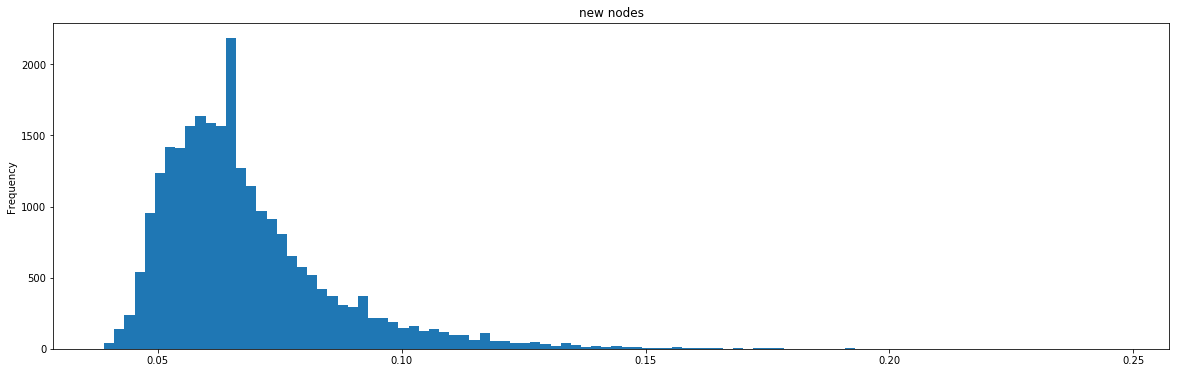

In [14]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['neighbor_updates'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes')

In [84]:
dfs['new']['coupling'].min()

0.0

In [45]:
# 47, 48 do more throttling than 0, 255. However, they appear to only do this throttling
# very, very early in the simulation (around timestep 10) but when they do it, it is
# significant (>2 seconds).
interesting_pes = [0, 255, 47, 48]

df = dfs['new']
interesting_dfs = {}
for pe in interesting_pes:
    interesting_dfs[pe] = df[df['pe'].isin([pe])].sort_values(by = 'timestep')

In [67]:
interesting_dfs[interesting_pes[0]].columns

Index([u'active_partitions', u'cache_age_misses', u'cache_hits',
       u'cache_misses', u'coupled_values', u'coupling', u'edges',
       u'edges_getmem', u'edges_updates', u'metadata', u'n_coupled_spins',
       u'n_neighbors', u'neighbor_updates', u'pe', u'spins', u'summary',
       u'summary_actor_partitions', u'summary_time_window',
       u'summary_update_neighbors', u'summary_update_neighbors_body',
       u'summary_update_neighbors_getmem', u'summary_update_neighbors_lock',
       u'summary_update_neighbors_unlock', u'throttling', u'timestep',
       u'total'],
      dtype='object')

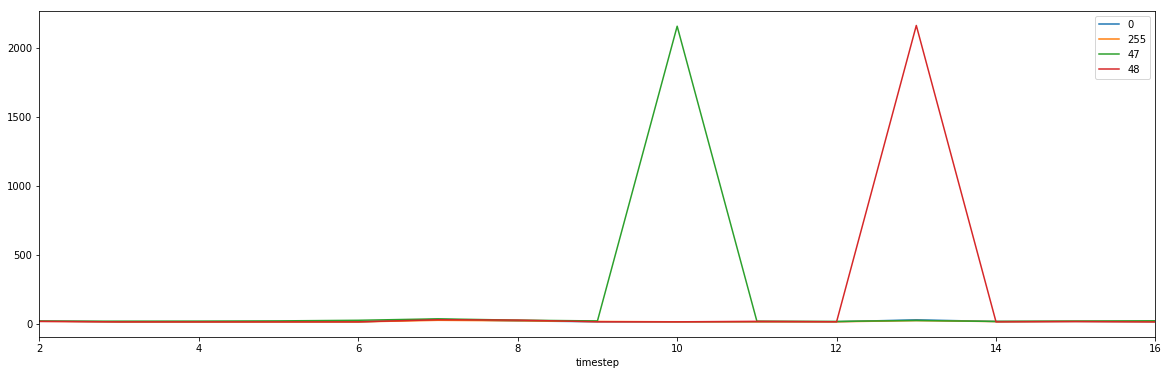

In [47]:
def plot_for_metric(metric):
    len_shortest_df = 15
    
    d = {'timestep': interesting_dfs[interesting_pes[0]]['timestep'].values[:len_shortest_df]}
    for pe in interesting_pes:
        d[str(pe)] = interesting_dfs[pe][metric].values[:len_shortest_df]
    
    pd.DataFrame(d).plot(kind = 'line', x = 'timestep', figsize = (20.0, 6.0))

plot_for_metric('total')

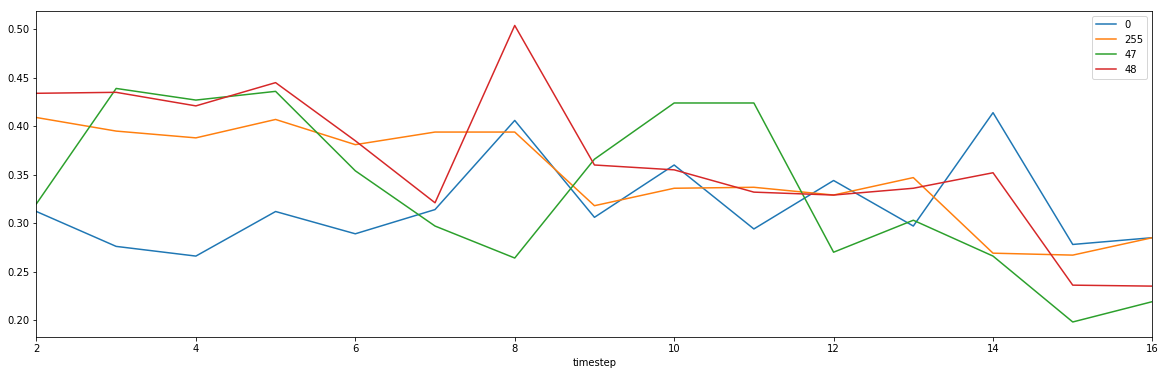

In [48]:
plot_for_metric('metadata')

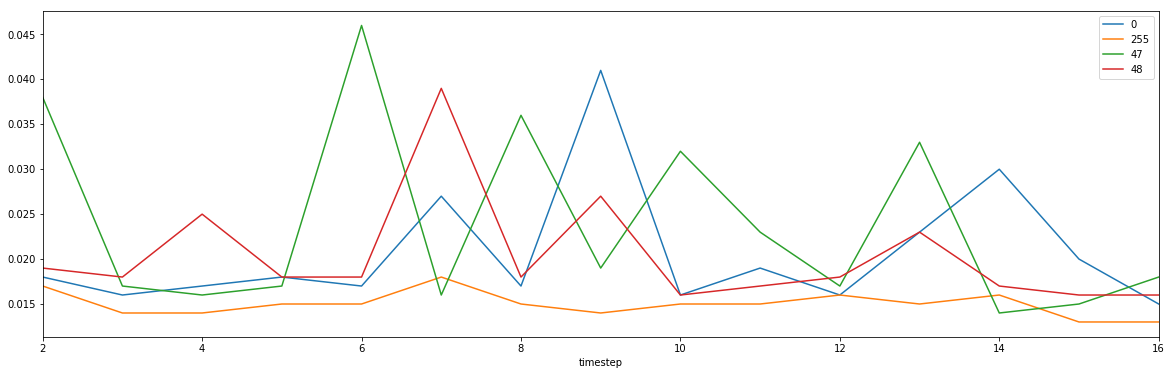

In [49]:
# 'coupled_values', 'coupling', 'edges', 'neighbor_updates', 'summary', 'throttling'
plot_for_metric('coupled_values')

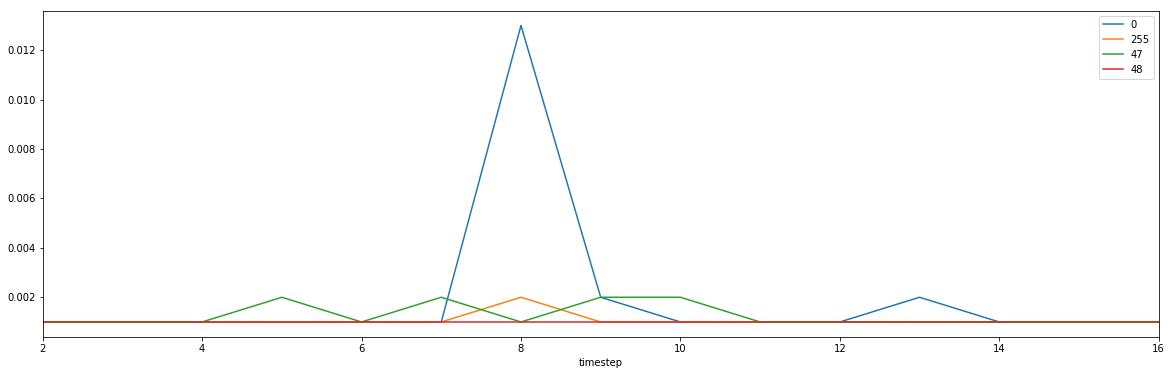

In [50]:
plot_for_metric('coupling')

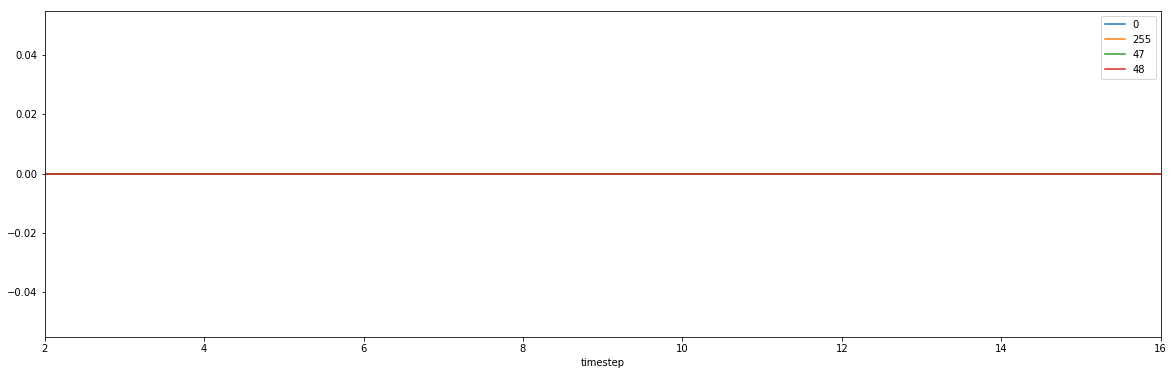

In [51]:
plot_for_metric('n_coupled_spins')

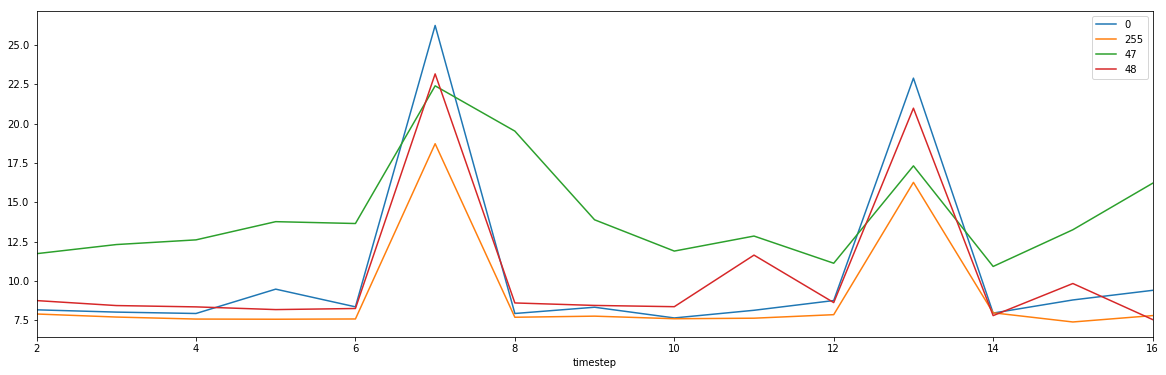

In [52]:
plot_for_metric('edges')

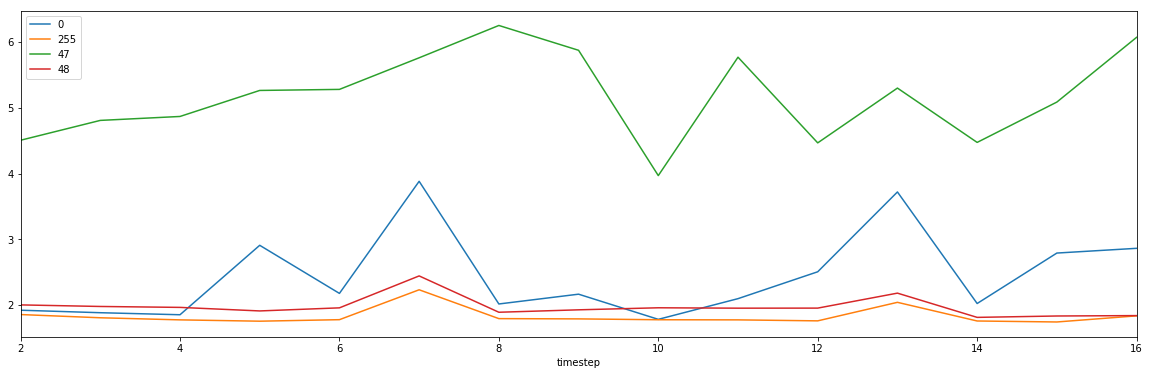

In [53]:
plot_for_metric('edges_updates')

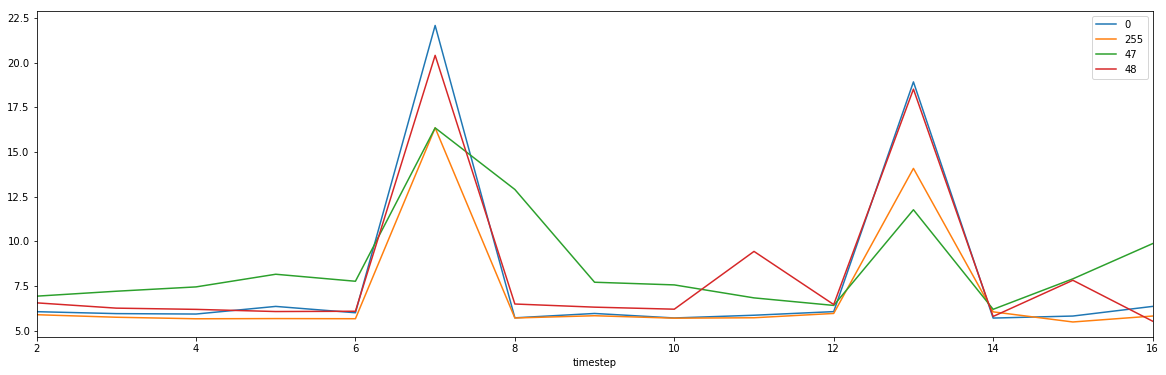

In [54]:
plot_for_metric('edges_getmem')

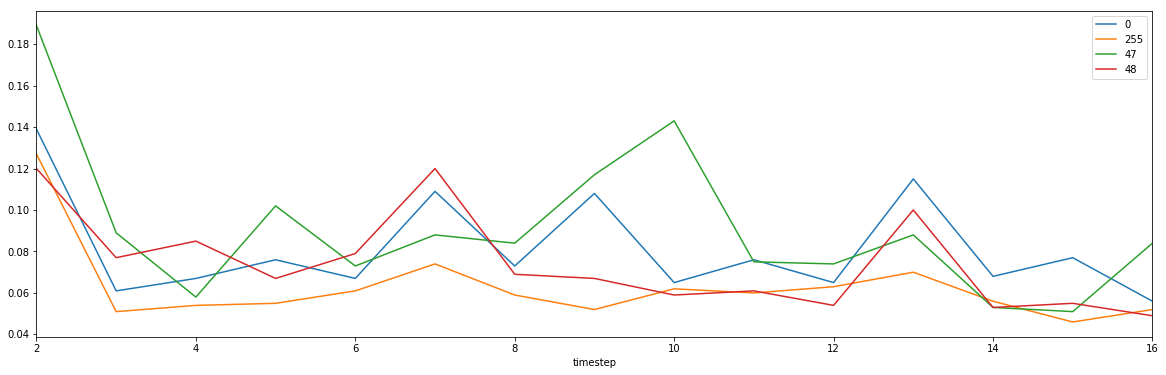

In [55]:
plot_for_metric('neighbor_updates')

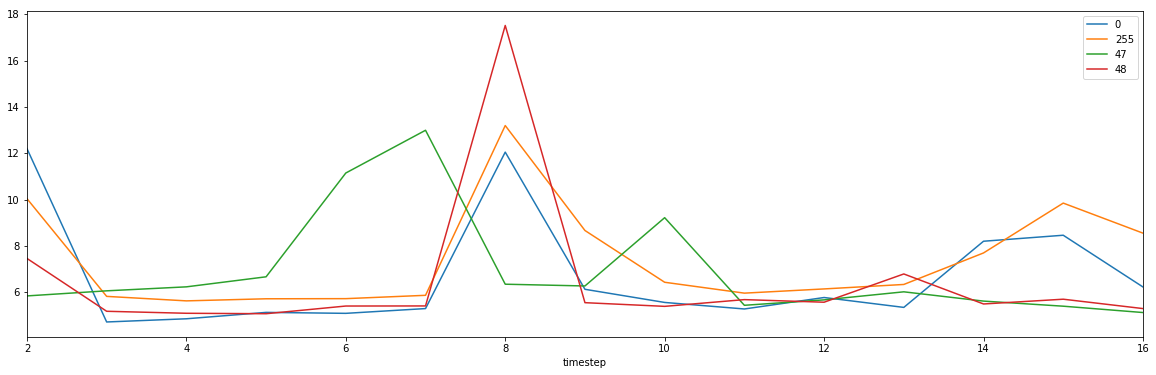

In [56]:
plot_for_metric('summary')

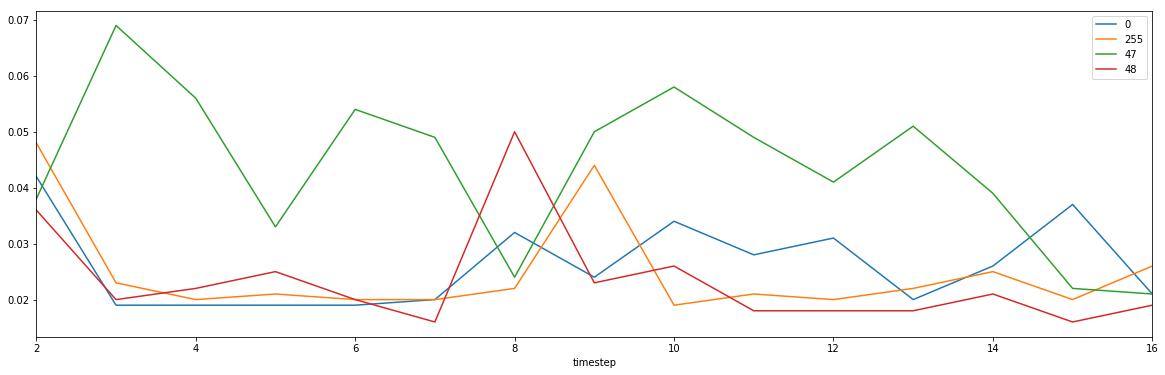

In [57]:
plot_for_metric('summary_actor_partitions')

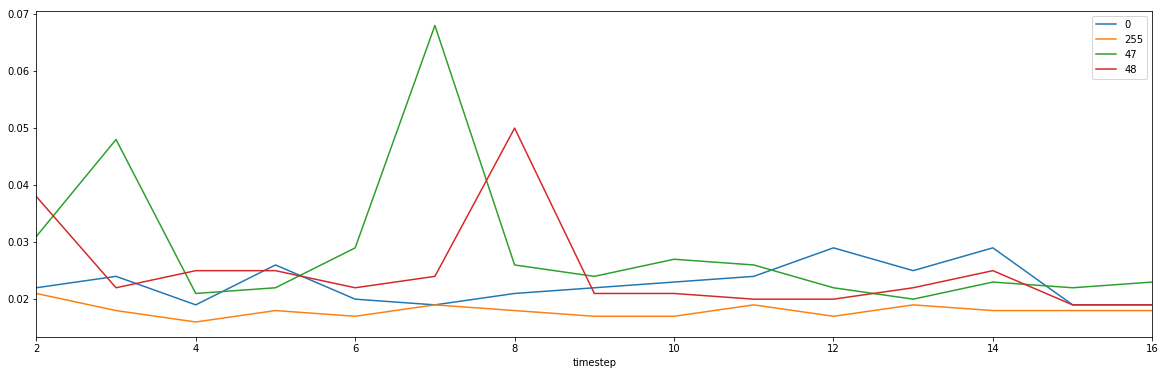

In [58]:
plot_for_metric('summary_time_window')

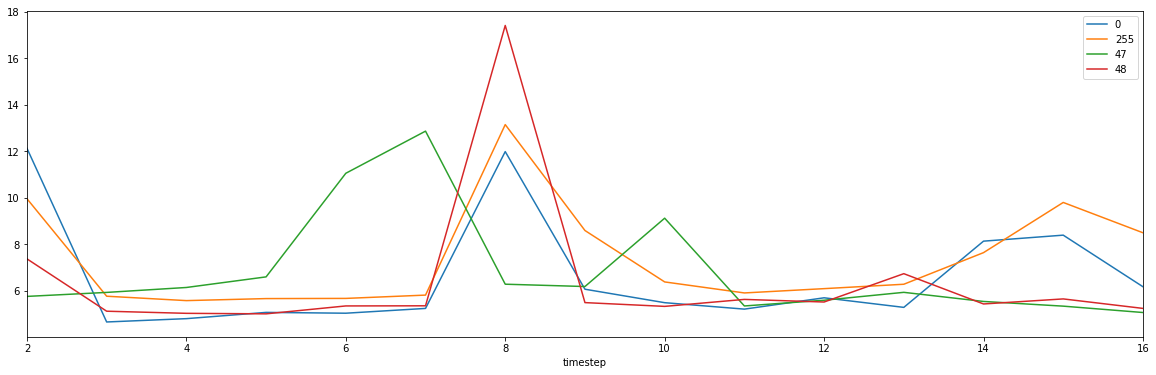

In [59]:
plot_for_metric('summary_update_neighbors')

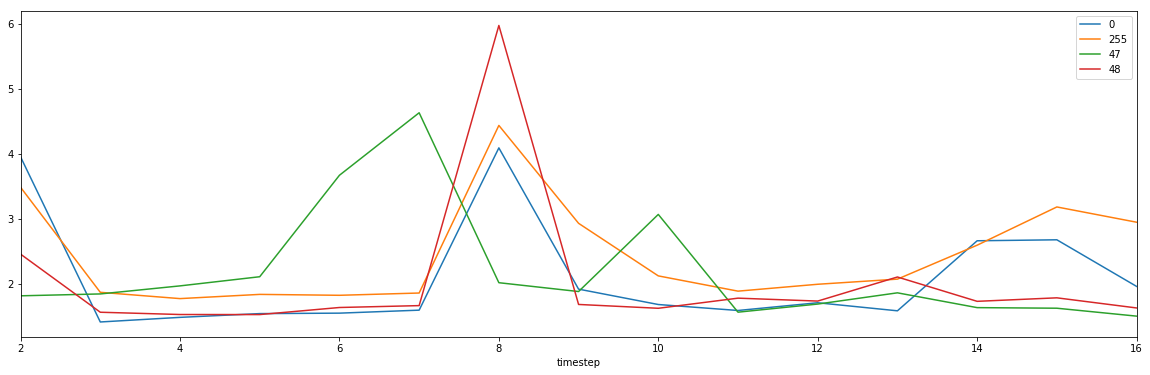

In [60]:
plot_for_metric('summary_update_neighbors_lock')

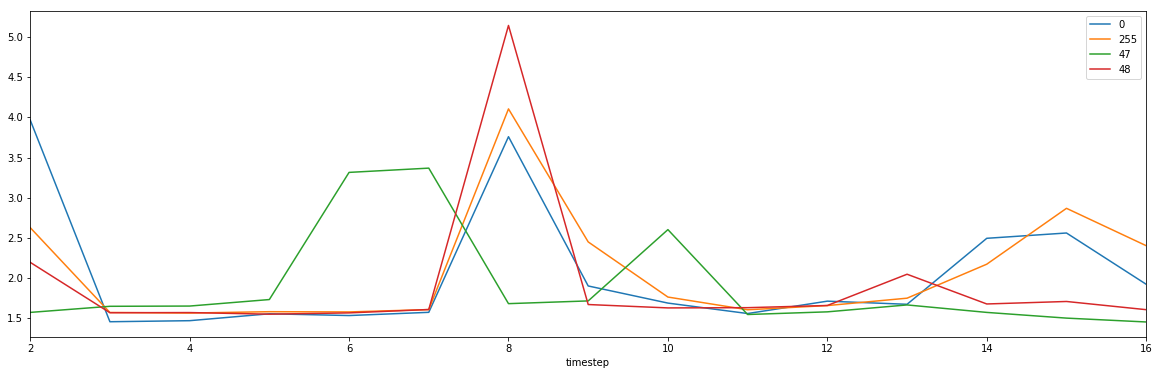

In [61]:
plot_for_metric('summary_update_neighbors_getmem')

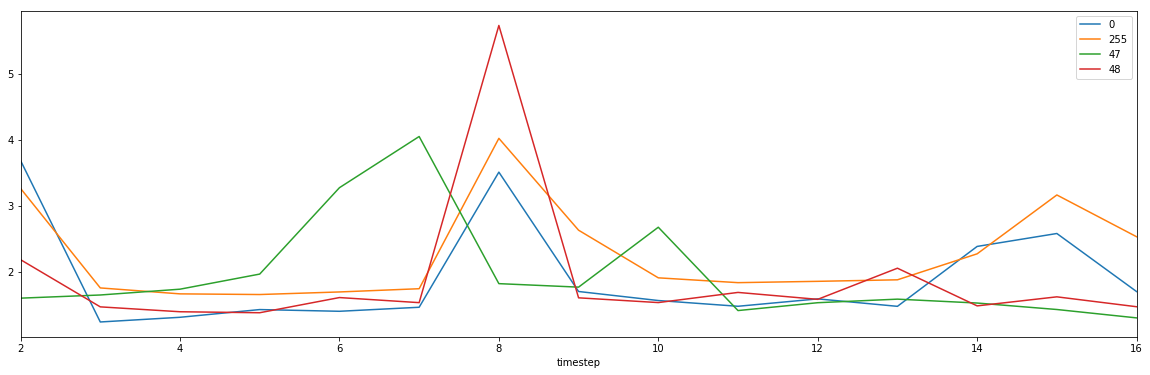

In [62]:
plot_for_metric('summary_update_neighbors_unlock')

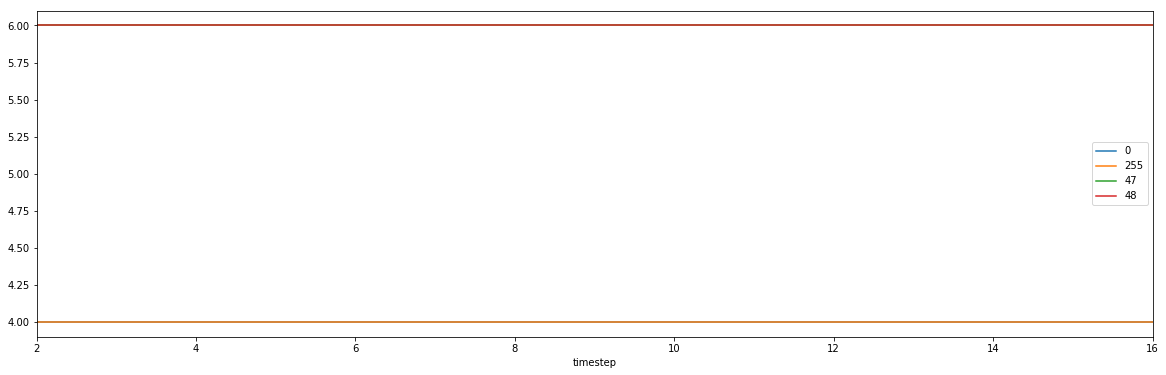

In [63]:
plot_for_metric('n_neighbors')

In [64]:
def compute_mean(metric):
    d = {}
    for pe in interesting_pes:
        d[pe] = interesting_dfs[pe][metric].mean()
    return d

compute_mean('n_neighbors')

{0: 4.0, 47: 6.0, 48: 6.0, 255: 4.0}

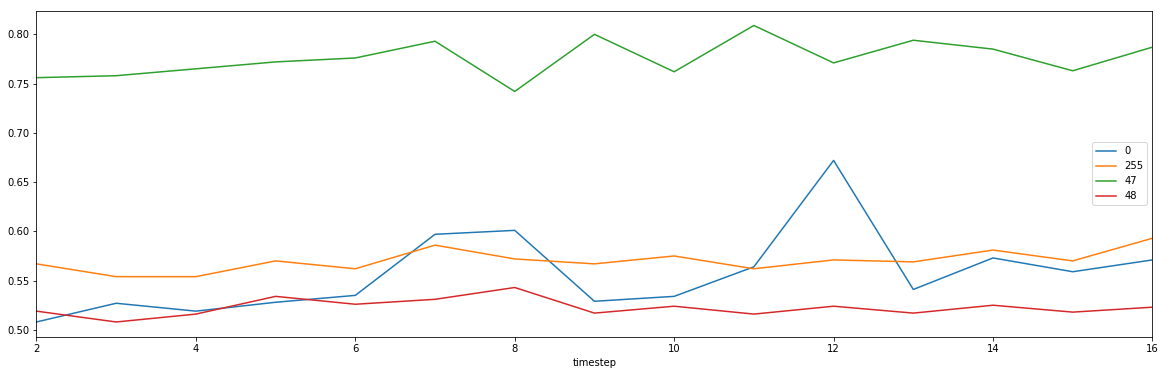

In [65]:
plot_for_metric('summary_update_neighbors_body')

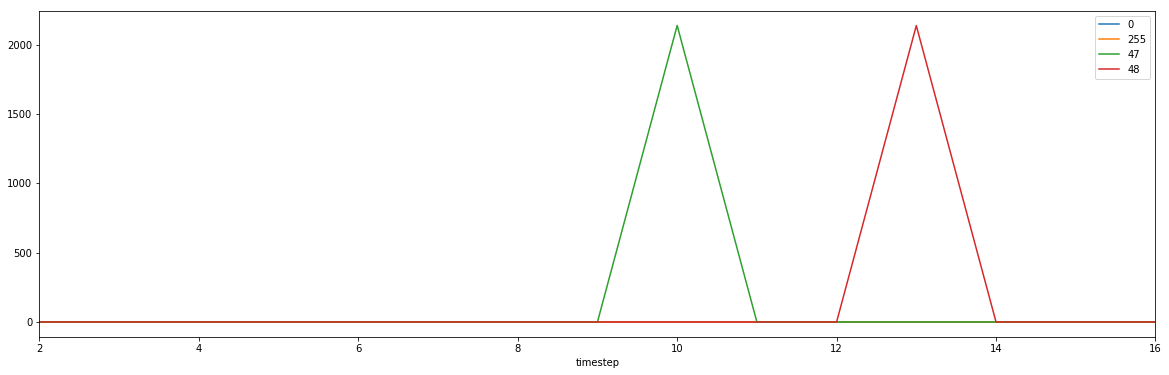

In [66]:
plot_for_metric('throttling')

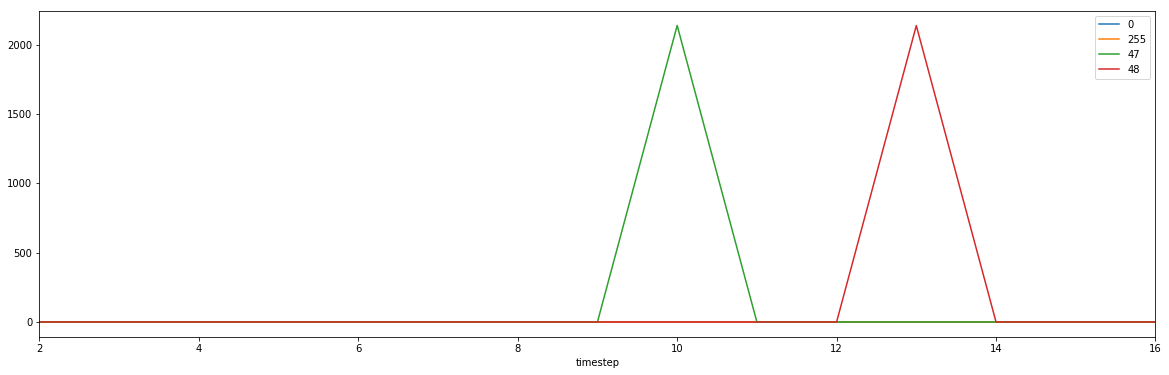

In [70]:
#[u'active_partitions', u'cache_age_misses', u'cache_hits',
#       u'cache_misses', u'coupled_values', u'coupling', u'edges',
#       u'edges_getmem', u'edges_updates', u'metadata', u'n_coupled_spins',
#       u'n_neighbors', u'neighbor_updates', u'pe', u'spins', u'summary',
#       u'summary_actor_partitions', u'summary_time_window',
#      u'summary_update_neighbors', u'summary_update_neighbors_body',
#       u'summary_update_neighbors_getmem', u'summary_update_neighbors_lock',
#       u'summary_update_neighbors_unlock', u'throttling', u'timestep',
#       u'total']
plot_for_metric('throttling')